In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from zipfile import ZipFile

In [ ]:
with ZipFile('/content/drive/MyDrive/American Sign Language Letters.v1-v1.coco-mmdetection.zip','r') as zipObj:
  zipObj.extractall('/content/drive/MyDrive/signmodel')

In [ ]:
import os
import shutil
import json

# Load the JSON file
json_file = '/content/drive/MyDrive/signmodel/train/_annotations.coco.json'
with open(json_file, 'r') as f:
    data = json.load(f)

# Extract the annotations and categories
annotations = data['annotations']
categories = {cat['id']: cat['name'] for cat in data['categories']}
images = {img['id']: img['file_name'] for img in data['images']}

# Create a directory for each label if it doesn't exist
output_dir = '/content/drive/MyDrive/signmodel/test'
os.makedirs(output_dir, exist_ok=True)

for category_name in categories.values():
    label_dir = os.path.join(output_dir, category_name)
    os.makedirs(label_dir, exist_ok=True)

# Move images to the corresponding label directories
for annotation in annotations:
    image_id = annotation['image_id']
    category_id = annotation['category_id']
    file_name = images[image_id]
    label_name = categories[category_id]

    source_path = os.path.join('/content/drive/MyDrive/signmodel/train', file_name)
    destination_path = os.path.join(output_dir, label_name, file_name)

    if os.path.exists(source_path):
        shutil.move(source_path, destination_path)
    else:
        print(f"File {source_path} does not exist and cannot be moved.")

print("Images sorted into label directories successfully.")


Images sorted into label directories successfully.


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Generator with Augmentation
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_IDs, labels, batch_size=32, dim=(224, 224), n_channels=3, n_classes=26, shuffle=True, augment=False):
        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
        self.datagen = ImageDataGenerator(
            rotation_range=30,
            width_shift_range=0.3,
            height_shift_range=0.3,
            shear_range=0.3,
            zoom_range=0.3,
            horizontal_flip=True,
            fill_mode='nearest'
        )

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=np.float32)
        y = np.empty((self.batch_size), dtype=int)

        for i, ID in enumerate(list_IDs_temp):
            img = cv2.imread(ID)
            img = cv2.resize(img, self.dim)
            if self.augment:
                img = self.datagen.random_transform(img)
            X[i,] = img
            y[i] = self.labels[ID]

        return X / 255.0, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

# Directory path
data_dir = "/content/drive/MyDrive/signmodel/signmodel"

# Create a function to retrieve the list of image paths and their corresponding labels
def get_image_list_and_labels(data_dir):
    image_list = []
    labels = sorted(os.listdir(data_dir))
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    label_dict = dict(zip(labels, encoded_labels))

    for label in labels:
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir):
            for image_name in os.listdir(label_dir):
                image_path = os.path.join(label_dir, image_name)
                image_list.append((image_path, label_dict[label]))

    return image_list, label_dict

image_list, label_dict = get_image_list_and_labels(data_dir)

# Split the data into train, validation, and test sets
train_val_videos, test_videos = train_test_split(image_list, test_size=0.3, random_state=42)
train_videos, val_videos = train_test_split(train_val_videos, test_size=0.5, random_state=42)

# Create data generators
train_generator = DataGenerator([x[0] for x in train_videos], {x[0]: x[1] for x in train_videos}, batch_size=32, shuffle=True, augment=True)
val_generator = DataGenerator([x[0] for x in val_videos], {x[0]: x[1] for x in val_videos}, batch_size=32, shuffle=False, augment=False)
test_generator = DataGenerator([x[0] for x in test_videos], {x[0]: x[1] for x in test_videos}, batch_size=32, shuffle=False, augment=False)

# Define and compile the model using a pre-trained model
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(26, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping]
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step - accuracy: 0.0650 - loss: 3.9061 - val_accuracy: 0.2344 - val_loss: 2.7419 - learning_rate: 0.0010
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 73s 4s/step - accuracy: 0.3259 - loss: 2.4131 - val_accuracy: 0.3854 - val_loss: 2.1072 - learning_rate: 0.0010
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.4928 - loss: 1.8033 - val_accuracy: 0.4774 - val_loss: 1.7676 - learning_rate: 0.0010
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.5015 - loss: 1.6804 - val_accuracy: 0.5556 - val_loss: 1.5108 - learning_rate: 0.0010
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.5556 - loss: 1.4727 - val_accuracy: 0.5955 - val_loss: 1.3528 - learning_rate: 0.0010
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step - accuracy: 0.6167 - loss: 1.2904 - val_accuracy: 0.6667 - val_loss: 1.1774 - learning_rate: 0.0010
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.6012 - loss: 1.2769 - val_accuracy: 0.6840 - va

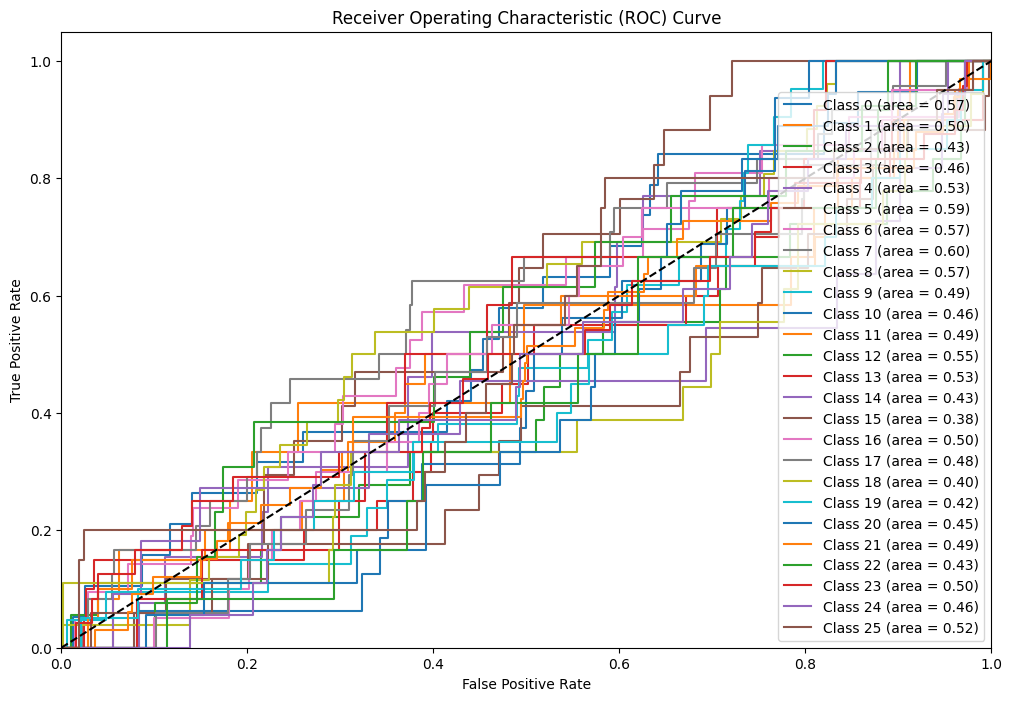

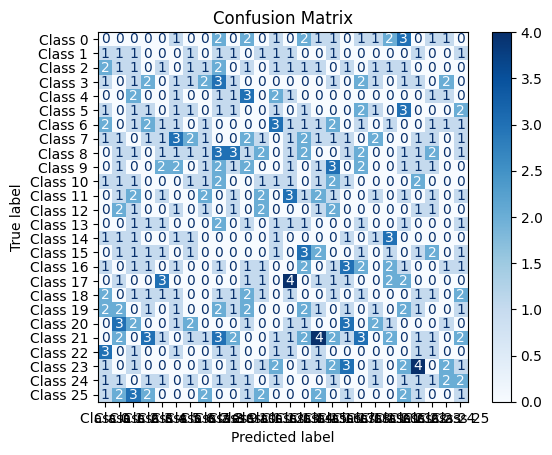

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Example data
n_classes = 26
y_true = np.random.randint(0, n_classes, size=(480,))
y_pred = np.random.randint(0, n_classes, size=(480,))
y_pred_prob = np.random.rand(480, n_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(12, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Compute and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Class {i}' for i in range(n_classes)])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [ ]:
print("y_true shape:", y_true.shape)
print("y_pred_prob shape:", y_pred_prob.shape)
print("Number of classes:", y_pred_prob.shape[1])


y_true shape: (480,)
y_pred_prob shape: (480, 26)
Number of classes: 26


In [ ]:
# Save the model
model.save('/content/drive/MyDrive/modeldraft3.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:

!tensorflowjs_converter --input_format keras --weight_shard_size_bytes 60000000 /content/drive/MyDrive/modeldraft3.h5 /content/drive/MyDrive/sign_model

2024-07-29 17:29:41.163844: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 17:29:41.271389: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 17:29:41.271505: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-29 17:29:44.118454: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
